# Objective
- O objetivo é treinar um modelo utilizando a descrição do produto para prever o setor e o território
- Vamos utilizar Word2Vec para trasformar a descrição em vetores (embeddings)
- Vamos utilizar um modelo XG boost para treinar

# Data
- Dados fornecidos pelo banco de Portugal

# Imports

In [1]:
import pandas as pd
import numpy as np
import gradio as gr
import pickle
import matplotlib.pyplot as plt

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from gensim.models import Word2Vec
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from feature_engine.encoding import RareLabelEncoder
from gensim.utils import simple_preprocess
from sklearn.metrics import accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, roc_auc_score

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/gradio_client/documentation.py:103: UserWarning: Could not get documentation group for <class 'gradio.mix.Parallel'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/gradio_client/documentation.py:103: UserWarning: Could not get documentation group for <class 'gradio.mix.Series'>: No known documentation group for module 'gradio.mix'
  warnings.warn(f"Could not get documentation group for {cls}: {exc}")


# Reading Data

In [2]:
df = pd.read_excel('../../data/01.Dataset FI_06032024.xlsx', sheet_name=2)

# Small Preprocessing

Mapeando o código ao nome da descrição

In [3]:
MAP_TipoInformacao = {"A": "ativo", "P": "passivo"}
MAP_TipoInstrumento = {"F21": "Numerário", "F22": "Depósitos transferíveis", "F29": "Outros depósitos", "F3_P": "Títulos de dívida", "F4": "Empréstimos", "F511": "Ações cotadas", "F512": "Ações não cotadas", "F519": "Outras participações", "F521": "Unidades de Participação emitidas por FMM", "F522": "Unidades de Participação emitidas por FI, excluindo FMM", "F71": "Derivados financeiros"}
MAP_MaturidadeOriginal = {"01": "A vista", "10": "Ate 1 ano", "06": "De 1 a 2 anos", "07": "De 2 a 5 anos", "08": "A mais de 5 anos", "_Z": "Não aplicável"}

In [4]:
df.TipoInformacao = df.TipoInformacao.map(MAP_TipoInformacao)
df.TipoInstrumento = df.TipoInstrumento.map(MAP_TipoInstrumento)
df.MaturidadeOriginal = df.MaturidadeOriginal.map(MAP_MaturidadeOriginal)

In [5]:
df.drop(["CodEntidadeRef", "CodEntidadeCon"], axis=1, inplace=True)

In [6]:
df.head(3)

,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,SetorInstitucionalCon,TerritorioCon
0,ativo,Depósitos transferíveis,BST Futuros 2.90%,A vista,S122,PRT
1,ativo,Depósitos transferíveis,BPI EUR 0.00%,A vista,S122,PRT
2,ativo,Depósitos transferíveis,BST Futuros 2.65%,A vista,S122,PRT


# Feature Engineering

In [7]:
df_clean = df.copy()

### Encoding Rare Labels

### Label Enconder

Criando funções para fazer o enconding dos targets

In [8]:
def encode_target(label, category_mapping):
  # Check if label is unseen (not in the dictionary)
  if label not in category_mapping:
    # Assign next available integer as seen in training data
    new_value = len(category_mapping)
    category_mapping[label] = new_value
  
  return category_mapping[label]

In [9]:
def map_numbers_to_categories(numbers, category_mapping):
    """Maps numbers back to their corresponding category names using a provided mapping dictionary.

    Args:
        numbers: A list or array containing the numerical representations of categories.
        category_mapping: A dictionary mapping category names (keys) to their numerical representations (values).

    Returns:
        A list containing the corresponding category names for the input numbers.
    """

    category_names = [category_mapping.get(number, None) for number in numbers]
    return category_names

In [10]:
def return_map(df_clean):

    territory_map = {}
    sector_map = {}

    # Iterate through each row (assuming TerritorioCon and encoded_label_territorio are in the same order)
    for territorio, encoded_label in zip(df_clean["TerritorioCon"], df_clean["encoded_label_territorio"]):
      # Add the mapping to the dictionary if the TerritorioCon is not already present
      if territorio not in territory_map:
        territory_map[territorio] = encoded_label
    
    for sector, encoded_label_sector in zip(df_clean["SetorInstitucionalCon"], df_clean["encoded_label_setor"]):
      # Add the mapping to the dictionary if the TerritorioCon is not already present
      if sector not in sector_map:
        sector_map[sector] = encoded_label_sector

    return territory_map, sector_map

Aplicando funções para mapear os targets a códigos pra podermos treinar o modelo

In [11]:
# Get unique categories from 'TerritorioCon' column
unique_categories_ter = df_clean['TerritorioCon'].unique()
category_mapping_ter = dict(zip(unique_categories_ter, range(len(unique_categories_ter))))
inverted_mapping_ter = {value: key for key, value in category_mapping_ter.items()}

unique_categories_sec = df_clean["SetorInstitucionalCon"].unique()
category_mapping_sec = dict(zip(unique_categories_sec, range(len(unique_categories_sec))))
inverted_mapping_sec = {value: key for key, value in category_mapping_sec.items()}

df_clean["encoded_label_territorio"] = df_clean["TerritorioCon"].apply(encode_target, args=[category_mapping_ter])
df_clean["encoded_label_setor"] = df_clean['SetorInstitucionalCon'].apply(encode_target, args=[category_mapping_sec])

In [12]:
df_clean.head(3)

,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor
0,ativo,Depósitos transferíveis,BST Futuros 2.90%,A vista,S122,PRT,0,0
1,ativo,Depósitos transferíveis,BPI EUR 0.00%,A vista,S122,PRT,0,0
2,ativo,Depósitos transferíveis,BST Futuros 2.65%,A vista,S122,PRT,0,0


### Processing Description Column

Vamos agora:
1. Utilizar a função simple_preprocess para aplicarmos tecnicas de Text Mining para limpar a descrição
2. Treinando o modelo Word2Vec para processar coluna com a descrição para vetores (Embeddings)

In [13]:
help(simple_preprocess)

Help on function simple_preprocess in module gensim.utils:

simple_preprocess(doc, deacc=False, min_len=2, max_len=15)
    Convert a document into a list of lowercase tokens, ignoring tokens that are too short or too long.

    Uses :func:`~gensim.utils.tokenize` internally.

    Parameters
    ----------
    doc : str
        Input document.
    deacc : bool, optional
        Remove accent marks from tokens using :func:`~gensim.utils.deaccent`?
    min_len : int, optional
        Minimum length of token (inclusive). Shorter tokens are discarded.
    max_len : int, optional
        Maximum length of token in result (inclusive). Longer tokens are discarded.

    Returns
    -------
    list of str
        Tokens extracted from `doc`.



In [14]:
df_clean['tokenized_Descricao_text'] = df_clean['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
word2vec_model = Word2Vec(sentences=df_clean['tokenized_Descricao_text'], vector_size=100, window=5, min_count=1, workers=4)

In [15]:
df_clean

,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor,tokenized_Descricao_text
0,ativo,Depósitos transferíveis,BST Futuros 2.90%,A vista,S122,PRT,0,0,"[bst, futuros]"
1,ativo,Depósitos transferíveis,BPI EUR 0.00%,A vista,S122,PRT,0,0,"[bpi, eur]"
2,ativo,Depósitos transferíveis,BST Futuros 2.65%,A vista,S122,PRT,0,0,"[bst, futuros]"
3,ativo,Depósitos transferíveis,BST EUR 3.15%,A vista,S122,PRT,0,0,"[bst, eur]"
4,ativo,Depósitos transferíveis,BST EUR 2.65%,A vista,S122,PRT,0,0,"[bst, eur]"
...,...,...,...,...,...,...,...,...,...
42402,passivo,Empréstimos,"Empréstimo Vic Management 0,01%",Não aplicável,S11,PRT,0,2,"[empréstimo, vic, management]"
42403,passivo,Títulos de dívida,Outros Passivos,De 2 a 5 anos,S122,BEL,10,0,"[outros, passivos]"
42404,passivo,Empréstimos,"Empréstimo Vic One Pest Sup 0,01%",Não aplicável,S11,PRT,0,2,"[empréstimo, vic, one, pest, sup]"
42405,passivo,Empréstimos,"Empréstimo Vic Management 0,01%",Não aplicável,S11,PRT,0,2,"[empréstimo, vic, management]"


In [238]:
df_clean.loc[[42404]]

,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor,tokenized_Descricao_text,avg_embedding
42404,passivo,Empréstimos,"Empréstimo Vic One Pest Sup 0,01%",Não aplicável,S11,PRT,0,2,"[empréstimo, vic, one, pest, sup]","[0.035756856, 0.12569085, -0.039439537, -0.024..."


In [232]:
df_clean.tokenized_Descricao_text.str.contains('sup')

0       NaN
1       NaN
2       NaN
3       NaN
4       NaN
         ..
42402   NaN
42403   NaN
42404   NaN
42405   NaN
42406   NaN
Name: tokenized_Descricao_text, Length: 42407, dtype: float64

In [230]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42407 entries, 0 to 42406
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   TipoInformacao            42407 non-null  object
 1   TipoInstrumento           42407 non-null  object
 2   DescricaoInstrumento      42407 non-null  object
 3   MaturidadeOriginal        42407 non-null  object
 4   SetorInstitucionalCon     42407 non-null  object
 5   TerritorioCon             42407 non-null  object
 6   encoded_label_territorio  42407 non-null  int64 
 7   encoded_label_setor       42407 non-null  int64 
 8   tokenized_Descricao_text  42407 non-null  object
 9   avg_embedding             42407 non-null  object
dtypes: int64(2), object(8)
memory usage: 3.2+ MB


In [16]:
def compute_avg_embedding(tokens, unknown_embedding=[0]*word2vec_model.vector_size):
    embeddings = [word2vec_model.wv[token] for token in tokens if token in word2vec_model.wv]
    if embeddings:  # Embeddings found
        return np.array(embeddings).mean(axis=0)  # Return average embedding as a NumPy array
    else:  # No embeddings found
        return np.array(unknown_embedding)

In [36]:
df_clean['avg_embedding'] = df_clean['tokenized_Descricao_text'].apply(compute_avg_embedding)
X = df_clean['avg_embedding'].apply(pd.Series).to_numpy()
y1 = df_clean['encoded_label_territorio']
y2 = df_clean['encoded_label_setor']
embed_data = pd.DataFrame(X)

In [37]:
df_clean.head(3)

,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor,tokenized_Descricao_text,avg_embedding
0,ativo,Depósitos transferíveis,BST Futuros 2.90%,A vista,S122,PRT,0,0,"[bst, futuros]","[0.21031791, 0.25123006, 0.16418047, 0.0532326..."
1,ativo,Depósitos transferíveis,BPI EUR 0.00%,A vista,S122,PRT,0,0,"[bpi, eur]","[-0.27860442, 0.56142604, -0.0020637675, -0.15..."
2,ativo,Depósitos transferíveis,BST Futuros 2.65%,A vista,S122,PRT,0,0,"[bst, futuros]","[0.21031791, 0.25123006, 0.16418047, 0.0532326..."


### Train Test Split

Separando os dados em treino e test. Vamos ter dois targets. Um para o setor e outro para o território

In [38]:
# Stratified split with 'TerritorioCon' as the stratification factor
#df_train, df_test = train_test_split(embed_data, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y1, test_size=0.1, random_state=41)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, test_size=0.1, random_state=41)

# Train 

## XG Boost

## Train the Model Territorio

In [148]:
clf_ter = XGBClassifier(random_state=42, max_depth=4)
clf_ter.fit(X_train_1, y_train_1, early_stopping_rounds=10, 
        eval_set=[(X_test_1, y_test_1)])

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.13633
[1]	validation_0-mlogloss:3.83512
[2]	validation_0-mlogloss:2.36772
[3]	validation_0-mlogloss:2.19907
[4]	validation_0-mlogloss:2.08778
[5]	validation_0-mlogloss:1.93451
[6]	validation_0-mlogloss:1.80767
[7]	validation_0-mlogloss:1.70481
[8]	validation_0-mlogloss:1.64878
[9]	validation_0-mlogloss:1.60102
[10]	validation_0-mlogloss:1.54879
[11]	validation_0-mlogloss:1.50902
[12]	validation_0-mlogloss:1.49091
[13]	validation_0-mlogloss:1.45700
[14]	validation_0-mlogloss:1.43658
[15]	validation_0-mlogloss:1.43059
[16]	validation_0-mlogloss:1.41060
[17]	validation_0-mlogloss:1.38229
[18]	validation_0-mlogloss:1.36956
[19]	validation_0-mlogloss:1.34629
[20]	validation_0-mlogloss:1.31824
[21]	validation_0-mlogloss:1.29888
[22]	validation_0-mlogloss:1.29494
[23]	validation_0-mlogloss:1.29427
[24]	validation_0-mlogloss:1.28586
[25]	validation_0-mlogloss:1.27119
[26]	validation_0-mlogloss:1.25595
[27]	validation_0-mlogloss:1.25183
[28]	validation_0-mlogloss:1.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Evaluate 

In [149]:
y_pred_test = clf_ter.predict(X_test_1)
y_pred_train = clf_ter.predict(X_train_1)

In [150]:
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_ter)
pred_train_str = map_numbers_to_categories(y_pred_train, inverted_mapping_ter)

In [151]:
model_names = []

territorio_accuracy_treino = []
territorio_precision_treino = []
territorio_recall_treino = []

territorio_accuracy_test = []
territorio_precision_test = []
territorio_recall_test = []

In [152]:
model_names.append("XG-Boost")

accuracy_test = accuracy_score(y_test_1.to_list(), y_pred_test)
accuracy_train = accuracy_score(y_train_1.to_list(), y_pred_train)
territorio_accuracy_treino.append(accuracy_train)
territorio_accuracy_test.append(accuracy_test)


precision_test = precision_score(y_test_1.to_list(), y_pred_test, average='weighted')
precision_train = precision_score(y_train_1.to_list(), y_pred_train, average='weighted')
territorio_precision_treino.append(precision_train)
territorio_precision_test.append(precision_test)


recall_test = recall_score(y_test_1.to_list(), y_pred_test, average='weighted')
recall_train = recall_score(y_train_1.to_list(), y_pred_train, average='weighted')
territorio_recall_treino.append(recall_train)
territorio_recall_test.append(recall_test)

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

In [153]:
# Evaluate accuracy
print("Accuracy Test:", accuracy_test)
print("Accuracy Train:", accuracy_train)

# Precision
print("Precision Test:", precision_test)
print("Precision Train:", precision_train)

# Recall
print("Recall Test:", recall_test)
print("Recall Train:", recall_train)

Accuracy Test: 0.8811601037491158
Accuracy Train: 0.9156579154221034
Precision Test: 0.88093405478856
Precision Train: 0.9156511306413154
Recall Test: 0.8811601037491158
Recall Train: 0.9156579154221034


In [154]:
report = classification_report(y_test_1, y_pred_test, output_dict=True)
# Convert the classification report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()
# Display the DataFrame
report_df.head()

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

,precision,recall,f1-score,support
0,0.875000,0.920908,0.897367,1277.0
1,0.858392,0.921201,0.888688,533.0
2,0.830357,0.805195,0.817582,231.0
3,0.790323,0.692580,0.738230,283.0
4,0.871595,0.861538,0.866538,260.0


### Analysis of cases that have failed

In [155]:
map_country_ter = {0: 'PRT',
 1: 'USA',
 2: 'NLD',
 3: 'ESP',
 4: 'DEU',
 5: 'LUX',
 6: 'GBR',
 7: 'CAN',
 8: 'FIN',
 9: 'CHE',
 10: 'BEL',
 11: 'FRA',
 12: 'IRL',
 13: 'ITA',
 14: 'DNK',
 15: 'SWE',
 16: 'AUS',
 19: 'JPN',
 21: 'AUT',
 22: 'JEY',
 23: 'NOR',
 27: 'CYM',
 33: 'MEX',
}
report_df_10 = report_df[report_df.support > 10].reset_index().round(2)
report_df_10.rename(columns={"index": "Ter"}, inplace=True)
report_df_10 = report_df_10.iloc[:-2]
report_df_10.Ter = report_df_10.Ter.astype(int)
report_df_10.Ter = report_df_10.Ter.map(map_country_ter)
report_df_10[["Ter", "precision", "support"]].sort_values("support", ascending=False)

,Ter,precision,support
0,PRT,0.88,1277.0
1,USA,0.86,533.0
5,LUX,0.85,339.0
11,FRA,0.92,326.0
3,ESP,0.79,283.0
4,DEU,0.87,260.0
2,NLD,0.83,231.0
12,IRL,0.92,201.0
6,GBR,0.89,171.0
13,ITA,0.98,161.0


In [156]:
map_country_ter = {
 25: 'KOR',
 43: 'IDN',
 49: 'EGY',
 52: 'BRA',
 59: 'MAR',
 61: '1E',
 62: 'BMU',
 70: 'GGY',
 82: 'ARG'}

report_df_10 = report_df[report_df.recall < 0.5].reset_index().round(2)
report_df_10.rename(columns={"index": "Ter"}, inplace=True)
report_df_10 = report_df_10.iloc[:-2]
report_df_10.Ter = report_df_10.Ter.astype(int)
report_df_10.Ter = report_df_10.Ter.map(map_country_ter)
report_df_10[["Ter", "precision", "support"]].sort_values("support", ascending=False)

,Ter,precision,support
3,BRA,0.38,7.0
2,EGY,1.00,6.0
0,KOR,0.00,1.0
1,IDN,0.00,1.0
4,MAR,0.00,1.0
5,1E,0.00,1.0
6,BMU,0.00,1.0


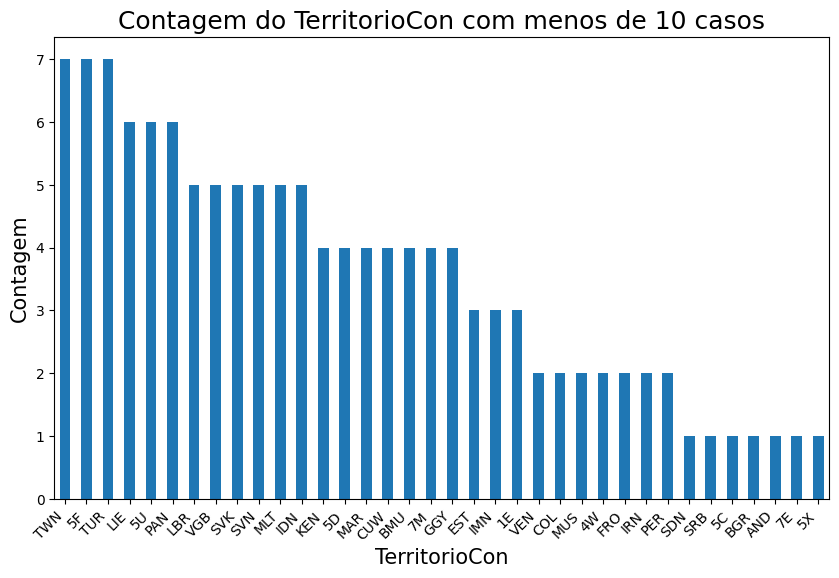

In [157]:
df_filtered = df_clean.groupby('TerritorioCon').filter(lambda x: len(x) < 10)
plt.figure(figsize=(10, 6))  # Increase the size of the plot
df_filtered.TerritorioCon.value_counts().plot(kind='bar')
plt.title('Contagem do TerritorioCon com menos de 10 casos', size=18)  # Add a title
plt.xlabel('TerritorioCon', size=15)  # Add x-axis label
plt.ylabel('Contagem', size=15)  # Add y-axis label
plt.xticks(rotation=45, ha='right')  # Optionally rotate x-axis labels for better readability
plt.show()

In [46]:
print("Classification Report:")
print(classification_report(y_test_1.to_list(), y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.92      0.90      1277
           1       0.86      0.92      0.89       533
           2       0.83      0.81      0.82       231
           3       0.79      0.69      0.74       283
           4       0.87      0.86      0.87       260
           5       0.85      0.87      0.86       339
           6       0.89      0.88      0.88       171
           7       0.96      0.96      0.96        23
           8       0.92      0.85      0.88        27
           9       0.93      0.95      0.94        56
          10       0.97      0.91      0.94        32
          11       0.92      0.86      0.89       326
          12       0.92      0.90      0.91       201
          13       0.97      0.97      0.97       161
          14       1.00      0.92      0.96        37
          15       0.98      0.92      0.95        53
          16       1.00      0.85      0.92        13
    

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modi

## Train Model Sector

In [105]:
clf_sec = XGBClassifier(random_state=42)
clf_sec.fit(X_train_2, y_train_2, early_stopping_rounds=10, 
        eval_set=[(X_test_2, y_test_2)])

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.55847
[1]	validation_0-mlogloss:1.26795
[2]	validation_0-mlogloss:1.07988
[3]	validation_0-mlogloss:0.94511
[4]	validation_0-mlogloss:0.84600
[5]	validation_0-mlogloss:0.76389
[6]	validation_0-mlogloss:0.70330
[7]	validation_0-mlogloss:0.65651
[8]	validation_0-mlogloss:0.62023
[9]	validation_0-mlogloss:0.58656
[10]	validation_0-mlogloss:0.55852
[11]	validation_0-mlogloss:0.53358
[12]	validation_0-mlogloss:0.51309
[13]	validation_0-mlogloss:0.49523
[14]	validation_0-mlogloss:0.48293
[15]	validation_0-mlogloss:0.46716
[16]	validation_0-mlogloss:0.45441
[17]	validation_0-mlogloss:0.44325
[18]	validation_0-mlogloss:0.43200
[19]	validation_0-mlogloss:0.42283
[20]	validation_0-mlogloss:0.41432
[21]	validation_0-mlogloss:0.40477
[22]	validation_0-mlogloss:0.39473
[23]	validation_0-mlogloss:0.38727
[24]	validation_0-mlogloss:0.37814
[25]	validation_0-mlogloss:0.37201
[26]	validation_0-mlogloss:0.36500
[27]	validation_0-mlogloss:0.36066
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [106]:
y_pred_test = clf_sec.predict(X_test_2)
y_pred_train = clf_sec.predict(X_train_2)

In [107]:
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_sec)
pred_train_str = map_numbers_to_categories(y_pred_train, inverted_mapping_sec)

In [108]:
setor_accuracy_treino = []
setor_precision_treino = []
setor_recall_treino = []

setor_accuracy_test = []
setor_precision_test = []
setor_recall_test = []

In [109]:
accuracy_test = accuracy_score(y_test_2.to_list(), y_pred_test)
accuracy_train = accuracy_score(y_train_2.to_list(), y_pred_train)
setor_accuracy_treino.append(accuracy_train)
setor_accuracy_test.append(accuracy_test)


precision_test = precision_score(y_test_2.to_list(), y_pred_test, average='weighted')
precision_train = precision_score(y_train_2.to_list(), y_pred_train, average='weighted')
setor_precision_treino.append(precision_train)
setor_precision_test.append(precision_test)


recall_test = recall_score(y_test_2.to_list(), y_pred_test, average='weighted')
recall_train = recall_score(y_train_2.to_list(), y_pred_train, average='weighted')
setor_recall_treino.append(recall_train)
setor_recall_test.append(recall_test)

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [110]:
# Evaluate accuracy
print("Accuracy Test:", accuracy_test)
print("Accuracy Train:", accuracy_train)

# Precision
print("Precision Test:", precision_test)
print("Precision Train:", precision_train)

# Recall
print("Recall Test:", recall_test)
print("Recall Train:", recall_train)

Accuracy Test: 0.9342136288611177
Accuracy Train: 0.9609862180998795
Precision Test: 0.932461132478097
Precision Train: 0.9603691791705778
Recall Test: 0.9342136288611177
Recall Train: 0.9609862180998795


In [118]:
report = classification_report(y_test_2, y_pred_test, output_dict=True)
# Convert the classification report to a pandas DataFrame
report_df = pd.DataFrame(report).transpose()
report_df = report_df.iloc[:-3]
# Display the DataFrame
report_df.head()

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

,precision,recall,f1-score,support
0,0.951893,0.967147,0.959459,1248.0
1,0.862385,0.706767,0.776860,133.0
2,0.931013,0.966491,0.948420,1522.0
3,0.855422,0.714765,0.778793,298.0
4,0.947977,0.987952,0.967552,332.0


In [120]:
report_df.sort_values("support", ascending=False)

,precision,recall,f1-score,support
2,0.931013,0.966491,0.948420,1522.0
0,0.951893,0.967147,0.959459,1248.0
8,0.982857,0.968105,0.975425,533.0
4,0.947977,0.987952,0.967552,332.0
3,0.855422,0.714765,0.778793,298.0
5,0.801527,0.760870,0.780669,138.0
1,0.862385,0.706767,0.776860,133.0
7,0.789474,0.750000,0.769231,20.0
9,1.000000,1.000000,1.000000,5.0
13,1.000000,0.600000,0.750000,5.0


In [121]:
inverted_mapping_sec

{0: 'S122',
 1: 'S126',
 2: 'S11',
 3: 'S127',
 4: 'S1311',
 5: 'S125',
 6: 'S1312',
 7: 'S128',
 8: 'S124',
 9: 'S123',
 10: 'S121',
 11: 'S1313',
 12: 'S1314',
 13: 'S14'}

In [146]:
map_country_sec = {0: 'S122',
 1: 'S126',
 2: 'S11',
 3: 'S127',
 4: 'S1311',
 5: 'S125',
 6: 'S1312',
 7: 'S128',
 8: 'S124',
 9: 'S123',
 10: 'S121',
 11: 'S1313',
 13: 'S14'}
report_df_10 = report_df.reset_index().round(2)
report_df_10.rename(columns={"index": "Sec"}, inplace=True)
report_df_10.Sec = report_df_10.Sec.astype(int)
report_df_10.Sec = report_df_10.Sec.map(map_country_sec)
report_df_10[["Sec", "precision", "support"]].sort_values("support", ascending=False)

,Sec,precision,support
2,S11,0.93,1522.0
0,S122,0.95,1248.0
8,S124,0.98,533.0
4,S1311,0.95,332.0
3,S127,0.86,298.0
5,S125,0.80,138.0
1,S126,0.86,133.0
7,S128,0.79,20.0
9,S123,1.00,5.0
12,S14,1.00,5.0


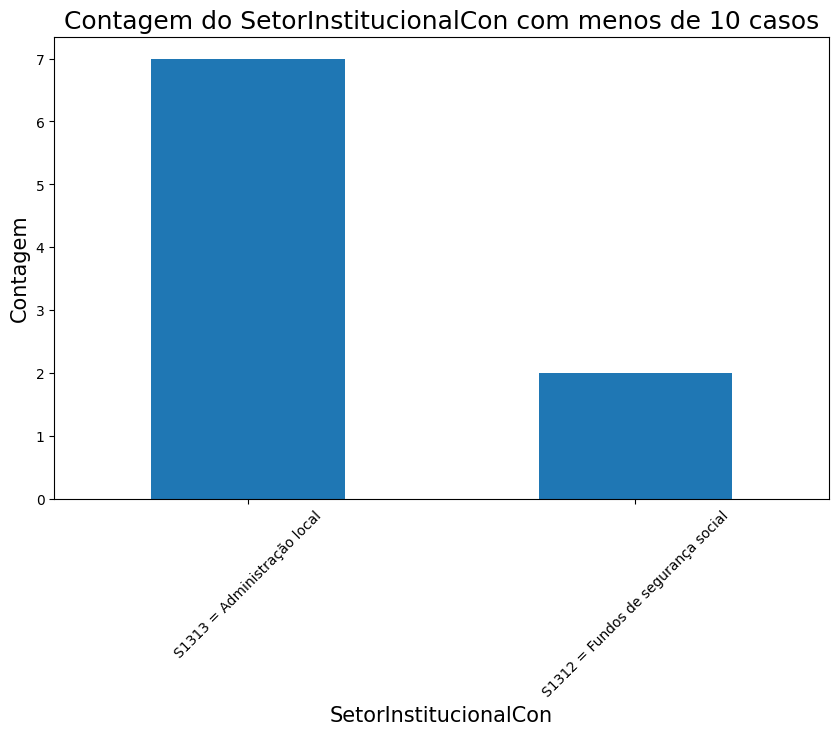

In [147]:
new_labels = ['S1313 = Administração local', 'S1312 = Fundos de segurança social']
df_filtered = df_clean.groupby('SetorInstitucionalCon').filter(lambda x: len(x) < 10)
plt.figure(figsize=(10, 6))  # Increase the size of the plot
ax = df_filtered.SetorInstitucionalCon.value_counts().plot(kind='bar')

num_bars = len(ax.patches)
new_labels = new_labels[:num_bars]

ax.set_xticklabels(new_labels, rotation=45, ha='center')
plt.title('Contagem do SetorInstitucionalCon com menos de 10 casos', size=18)  # Add a title
plt.xlabel('SetorInstitucionalCon', size=15)  # Add x-axis label
plt.ylabel('Contagem', size=15)  # Add y-axis label
#plt.xticks(rotation=45, ha='right')  # Optionally rotate x-axis labels for better readability
plt.show()

In [134]:
### print("Classification Report:")
print(classification_report(y_test_2.to_list(), y_pred_test))

              precision    recall  f1-score   support

           0       0.95      0.97      0.96      1248
           1       0.86      0.71      0.78       133
           2       0.93      0.97      0.95      1522
           3       0.86      0.71      0.78       298
           4       0.95      0.99      0.97       332
           5       0.80      0.76      0.78       138
           6       1.00      1.00      1.00         2
           7       0.79      0.75      0.77        20
           8       0.98      0.97      0.98       533
           9       1.00      1.00      1.00         5
          10       0.75      0.75      0.75         4
          11       0.00      0.00      0.00         1
          13       1.00      0.60      0.75         5

    accuracy                           0.93      4241
   macro avg       0.84      0.78      0.80      4241
weighted avg       0.93      0.93      0.93      4241



/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

## Train more models

In [34]:
modelos = {
    'Decision Tree': DecisionTreeClassifier(max_depth=3),
    'KNN': KNeighborsClassifier(n_neighbors=5),  # Ajuste o valor de k
    'Regressão Logística': LogisticRegression(multi_class='multinomial'),
    'SVM':  SVC()
}

In [35]:
# Treinar e avaliar cada modelo
for nome_modelo, modelo in modelos.items():
    
    # Treinar o modelo
    modelo.fit(X_train_1, y_train_1)
    
    y_pred_test = modelo.predict(X_test_1)
    y_pred_train = modelo.predict(X_train_1)
    
    model_names.append(nome_modelo)
    
    accuracy_test = accuracy_score(y_test_1.to_list(), y_pred_test)
    accuracy_train = accuracy_score(y_train_1.to_list(), y_pred_train)
    territorio_accuracy_treino.append(accuracy_train)
    territorio_accuracy_test.append(accuracy_test)


    precision_test = precision_score(y_test_1.to_list(), y_pred_test, average='weighted')
    precision_train = precision_score(y_train_1.to_list(), y_pred_train, average='weighted')
    territorio_precision_treino.append(precision_train)
    territorio_precision_test.append(precision_test)


    recall_test = recall_score(y_test_1.to_list(), y_pred_test, average='weighted')
    recall_train = recall_score(y_train_1.to_list(), y_pred_train, average='weighted')
    territorio_recall_treino.append(recall_train)
    territorio_recall_test.append(recall_test)

/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/

In [36]:
# Treinar e avaliar cada modelo
for nome_modelo, modelo in modelos.items():
    
    # Treinar o modelo
    modelo.fit(X_train_2, y_train_2)
    
    y_pred_test = modelo.predict(X_test_2)
    y_pred_train = modelo.predict(X_train_2)
    
    
    accuracy_test = accuracy_score(y_test_2.to_list(), y_pred_test)
    accuracy_train = accuracy_score(y_train_2.to_list(), y_pred_train)
    setor_accuracy_treino.append(accuracy_train)
    setor_accuracy_test.append(accuracy_test)


    precision_test = precision_score(y_test_2.to_list(), y_pred_test, average='weighted')
    precision_train = precision_score(y_train_2.to_list(), y_pred_train, average='weighted')
    setor_precision_treino.append(precision_train)
    setor_precision_test.append(precision_test)


    recall_test = recall_score(y_test_2.to_list(), y_pred_test, average='weighted')
    recall_train = recall_score(y_train_2.to_list(), y_pred_train, average='weighted')
    setor_recall_treino.append(recall_train)
    setor_recall_test.append(recall_test)

/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/

## Plot da Performance dos Modelos

In [37]:
territorio_performance_df = pd.DataFrame({"Accuracy Treino": territorio_accuracy_treino,"Accuracy Test": territorio_accuracy_test, "Precision Treino": territorio_precision_treino, "Precision Test": territorio_precision_test, "Recall Treino": territorio_recall_treino, "Recall Test": territorio_recall_test}, index=model_names)
territorio_performance_df= territorio_performance_df.round(2)
territorio_performance_df

,Accuracy Treino,Accuracy Test,Precision Treino,Precision Test,Recall Treino,Recall Test
XG-Boost,0.90,0.87,0.90,0.87,0.90,0.87
Decision Tree,0.43,0.42,0.32,0.31,0.43,0.42
KNN,0.90,0.88,0.90,0.88,0.90,0.88
Regressão Logística,0.55,0.55,0.54,0.54,0.55,0.55
SVM,0.55,0.54,0.59,0.58,0.55,0.54


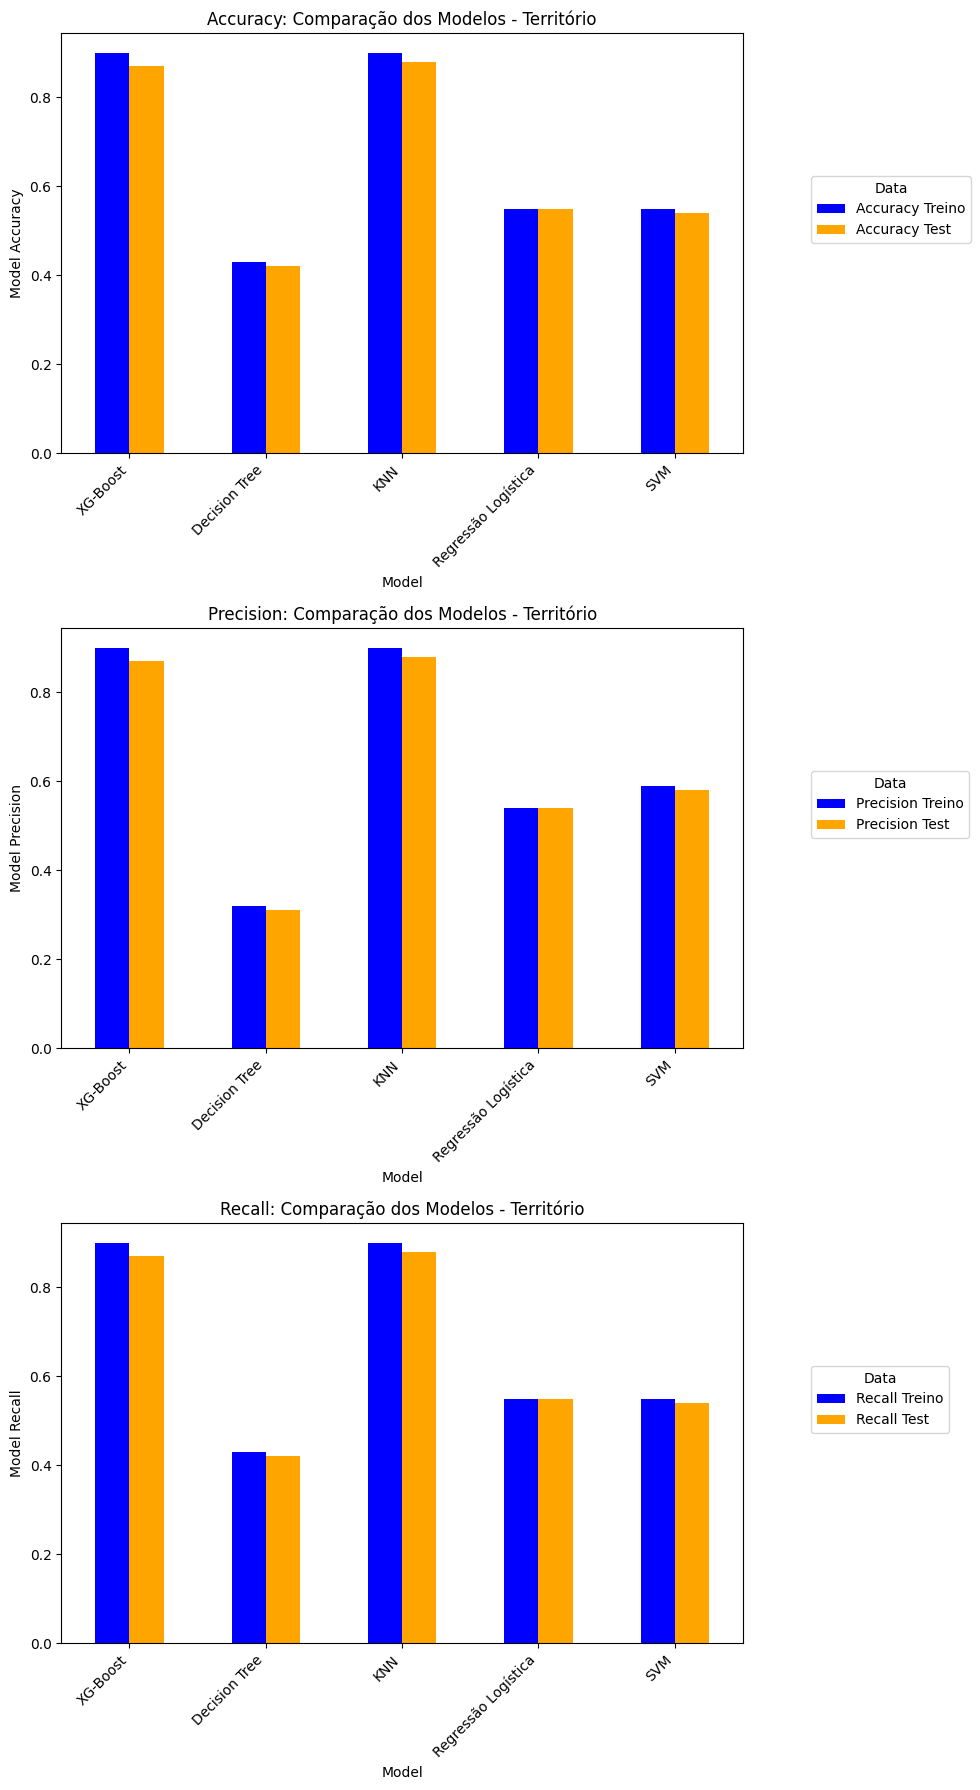

In [38]:
# Reset the DataFrame index
df_reseted = territorio_performance_df.reset_index()

# Define colors for each model
colors = ['blue', 'orange']  # Adjust colors as needed

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # Adjust figure size if necessary

# Define the metrics and corresponding labels
metrics = ['Accuracy', 'Precision', 'Recall']
y_labels = ['Model Accuracy', 'Model Precision', 'Model Recall']

for i, metric in enumerate(metrics):
    # Plot the metric for both training and test sets
    bars = df_reseted.plot(kind='bar', x='index', y=[f'{metric} Treino', f'{metric} Test'], stacked=False, color=colors, ax=axs[i])
    
    # Customize the chart
    axs[i].set_title(f'{metric}: Comparação dos Modelos - Território')
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(y_labels[i])
    axs[i].legend(title='Data', loc=(1.1, 0.5))
    axs[i].set_xticklabels(df_reseted['index'], rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

In [39]:
setor_performance_df = pd.DataFrame({"Accuracy Treino": setor_accuracy_treino,"Accuracy Test": setor_accuracy_test, "Precision Treino": setor_precision_treino, "Precision Test": setor_precision_test, "Recall Treino": setor_recall_treino, "Recall Test": setor_recall_test}, index=model_names)
setor_performance_df.round(2)

,Accuracy Treino,Accuracy Test,Precision Treino,Precision Test,Recall Treino,Recall Test
XG-Boost,0.96,0.93,0.96,0.93,0.96,0.93
Decision Tree,0.60,0.59,0.55,0.54,0.60,0.59
KNN,0.92,0.89,0.92,0.89,0.92,0.89
Regressão Logística,0.68,0.68,0.70,0.72,0.68,0.68
SVM,0.69,0.68,0.74,0.74,0.69,0.68


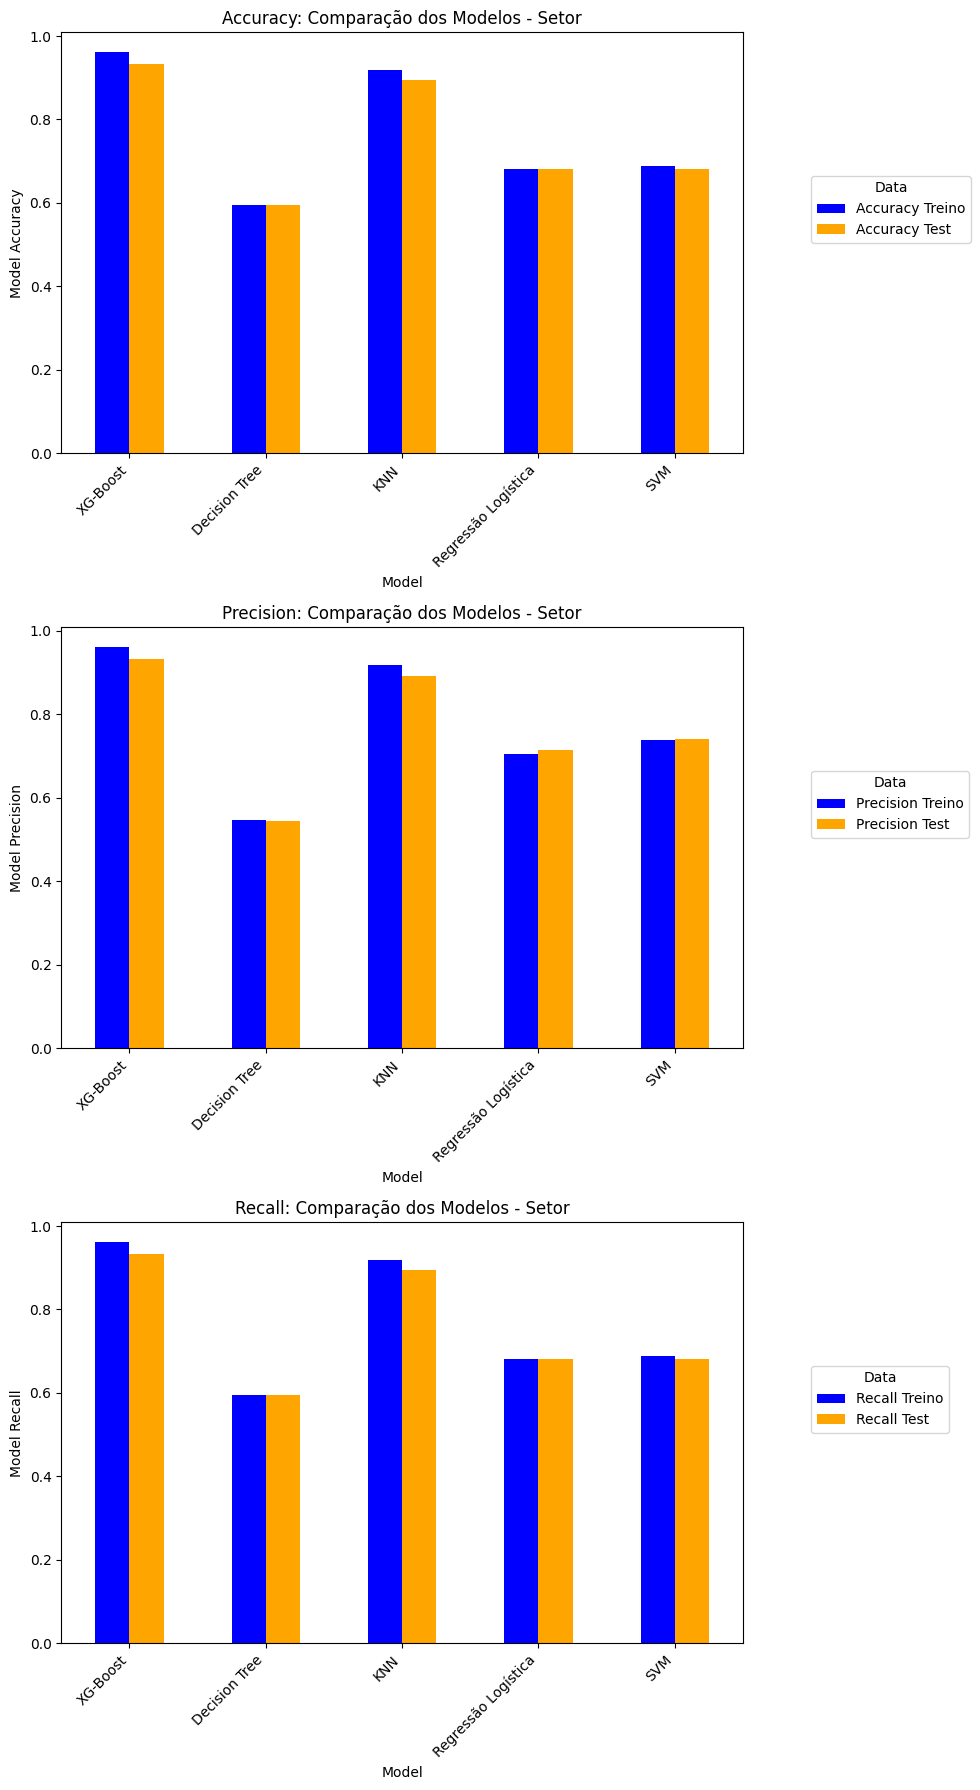

In [40]:
# Reset the DataFrame index
df_reseted = setor_performance_df.reset_index()

# Define colors for each model
colors = ['blue', 'orange']  # Adjust colors as needed

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(10, 18))  # Adjust figure size if necessary

# Define the metrics and corresponding labels
metrics = ['Accuracy', 'Precision', 'Recall']
y_labels = ['Model Accuracy', 'Model Precision', 'Model Recall']

for i, metric in enumerate(metrics):
    # Plot the metric for both training and test sets
    bars = df_reseted.plot(kind='bar', x='index', y=[f'{metric} Treino', f'{metric} Test'], stacked=False, color=colors, ax=axs[i])
    
    # Customize the chart
    axs[i].set_title(f'{metric}: Comparação dos Modelos - Setor')
    axs[i].set_xlabel('Model')
    axs[i].set_ylabel(y_labels[i])
    axs[i].legend(title='Data', loc=(1.1, 0.5))
    axs[i].set_xticklabels(df_reseted['index'], rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

## Treinar o melhor modelo com mais Atributos

In [239]:
new_features = ["TipoInformacao", "TipoInstrumento", "MaturidadeOriginal"]
df_to_get_dummies = df_clean[new_features]
dummies = pd.get_dummies(df_to_get_dummies)

new_df_to_train = pd.concat([embed_data, dummies], axis=1)

In [240]:
# Stratified split with 'TerritorioCon' as the stratification factor
#df_train, df_test = train_test_split(embed_data, test_size=0.2, random_state=42)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(new_df_to_train, y1, test_size=0.1, random_state=41)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(new_df_to_train, y2, test_size=0.1, random_state=41)

## Train 

## Train the Model Territorio

In [241]:
clf_ter = XGBClassifier(random_state=42, max_depth=4)
clf_ter.fit(X_train_1, y_train_1, early_stopping_rounds=10, 
        eval_set=[(X_test_1, y_test_1)])

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:2.04394
[1]	validation_0-mlogloss:3.08902
[2]	validation_0-mlogloss:1.86636
[3]	validation_0-mlogloss:1.64510
[4]	validation_0-mlogloss:1.54188
[5]	validation_0-mlogloss:1.47025
[6]	validation_0-mlogloss:1.42211
[7]	validation_0-mlogloss:1.39470
[8]	validation_0-mlogloss:1.34085
[9]	validation_0-mlogloss:1.30645
[10]	validation_0-mlogloss:1.26985
[11]	validation_0-mlogloss:1.24626
[12]	validation_0-mlogloss:1.21389
[13]	validation_0-mlogloss:1.17374
[14]	validation_0-mlogloss:1.13873
[15]	validation_0-mlogloss:1.11059
[16]	validation_0-mlogloss:1.08663
[17]	validation_0-mlogloss:1.06914
[18]	validation_0-mlogloss:1.05591
[19]	validation_0-mlogloss:1.03746
[20]	validation_0-mlogloss:1.02119
[21]	validation_0-mlogloss:1.00753
[22]	validation_0-mlogloss:0.99225
[23]	validation_0-mlogloss:0.97966
[24]	validation_0-mlogloss:0.96801
[25]	validation_0-mlogloss:0.95097
[26]	validation_0-mlogloss:0.93059
[27]	validation_0-mlogloss:0.91609
[28]	validation_0-mlogloss:0.8

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

## Evaluate 

In [242]:
y_pred_test = clf_ter.predict(X_test_1)
y_pred_train = clf_ter.predict(X_train_1)

pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_ter)
pred_train_str = map_numbers_to_categories(y_pred_train, inverted_mapping_ter)

In [243]:
accuracy_test = accuracy_score(y_test_1.to_list(), y_pred_test)
accuracy_train = accuracy_score(y_train_1.to_list(), y_pred_train)

precision_train = precision_score(y_train_1.to_list(), y_pred_train, average='weighted')
precision_test = precision_score(y_test_1.to_list(), y_pred_test, average='weighted')

recall_test = recall_score(y_test_1.to_list(), y_pred_test, average='weighted')
recall_train = recall_score(y_train_1.to_list(), y_pred_train, average='weighted')

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [244]:
accuracy_train

0.9408897972016979

In [245]:
accuracy_test

0.9047394482433389

In [246]:
models_names = ["XG_Boost", "XG Boost - More Features"]
accuracy_treino_ter = [territorio_accuracy_treino[0], accuracy_train]
accuracy_test_ter = [territorio_accuracy_test[0], accuracy_test]

precision_treino_ter = [territorio_precision_treino[0], precision_train]
precision_test_ter = [territorio_precision_test[0], precision_test]

recall_treino_ter = [territorio_recall_treino[0], recall_train]
recall_test_ter = [territorio_recall_test[0], recall_test]

In [247]:
data_performance = pd.DataFrame({"Accuracy Treino": accuracy_treino_ter,"Accuracy Teste": accuracy_test_ter, "Precision Treino": precision_treino_ter, "Precision Teste": precision_test_ter, "Recall Treino": recall_treino_ter, "Recall Teste": recall_test_ter}, index=models_names).T
data_performance["uplift"] = (data_performance["XG Boost - More Features"] - data_performance["XG_Boost"]) / data_performance["XG_Boost"]
data_performance['uplift'] = data_performance['uplift'].apply(lambda x: '{:.2%}'.format(x))
data_performance.round(2)
data_performance

,XG_Boost,XG Boost - More Features,uplift
Accuracy Treino,0.915658,0.940890,2.76%
Accuracy Teste,0.881160,0.904739,2.68%
Precision Treino,0.915651,0.940558,2.72%
Precision Teste,0.880934,0.904165,2.64%
Recall Treino,0.915658,0.940890,2.76%
Recall Teste,0.881160,0.904739,2.68%


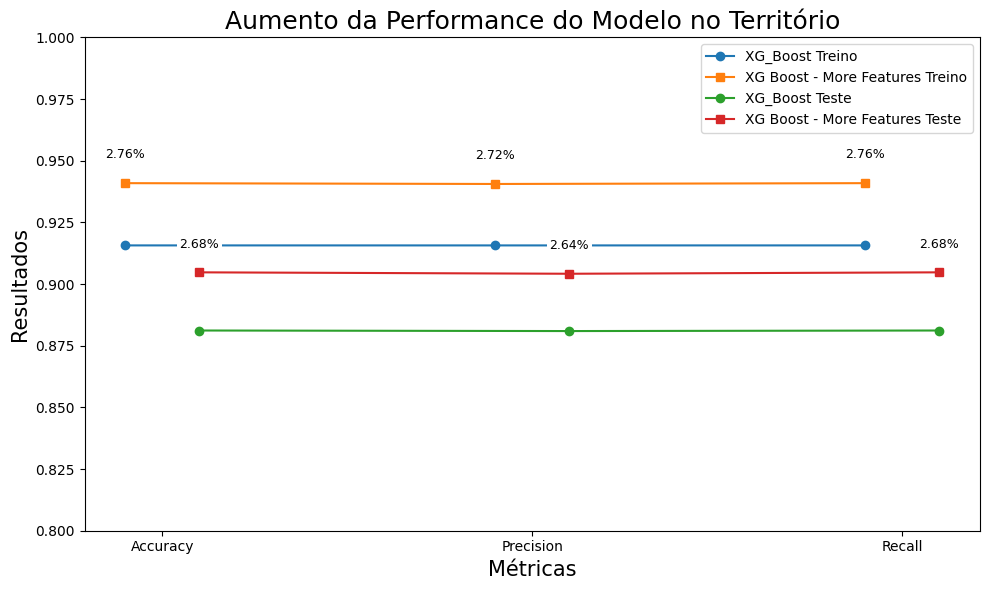

In [249]:
# Preparing the data
metrics = ['Accuracy', 'Precision', 'Recall']
types = ['Treino', 'Teste']
x = np.arange(len(metrics))  # the label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data for both models
for i, type in enumerate(types):
    xg_boost_scores = data_performance.loc[[f'{metric} {type}' for metric in metrics], 'XG_Boost']
    xg_boost_more_features_scores = data_performance.loc[[f'{metric} {type}' for metric in metrics], 'XG Boost - More Features']
    
    # Line plots for each model
    line1, = ax.plot(x + i*0.2, xg_boost_scores, marker='o', linestyle='-', label=f'XG_Boost {type}')
    line2, = ax.plot(x + i*0.2, xg_boost_more_features_scores, marker='s', linestyle='-', label=f'XG Boost - More Features {type}')
    
    # Annotating the uplift for each metric
    for j, metric in enumerate(metrics):
        uplift = data_performance.loc[f'{metric} {type}', 'uplift']
        higher_score = max(xg_boost_scores.iloc[j], xg_boost_more_features_scores.iloc[j])
        ax.text(x[j] + i*0.2, higher_score + 0.01, f'{uplift}', ha='center', fontsize=9, bbox=dict(facecolor='white', edgecolor='none', pad=2))

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Resultados', size=15)
ax.set_xlabel('Métricas', size=15)
ax.set_title('Aumento da Performance do Modelo no Território', size=18)
ax.set_xticks(x + 0.1)  # Adjusting x-ticks to be in the middle of the groups
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0.8, 1)

fig.tight_layout()
plt.show()

In [168]:
print("Classification Report:")
print(classification_report(y_test_1.to_list(), y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      1277
           1       0.90      0.93      0.91       533
           2       0.85      0.84      0.84       231
           3       0.78      0.81      0.80       283
           4       0.89      0.85      0.87       260
           5       0.88      0.89      0.89       339
           6       0.89      0.87      0.88       171
           7       0.88      0.96      0.92        23
           8       1.00      0.85      0.92        27
           9       0.87      0.96      0.92        56
          10       1.00      0.91      0.95        32
          11       0.90      0.89      0.89       326
          12       0.88      0.92      0.90       201
          13       0.98      0.99      0.98       161
          14       0.97      0.92      0.94        37
          15       1.00      0.92      0.96        53
          16       1.00      0.85      0.92        13
    

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

## Train Model Sector

In [250]:
clf_sec = XGBClassifier(random_state=42)
clf_sec.fit(X_train_2, y_train_2, early_stopping_rounds=10, 
        eval_set=[(X_test_2, y_test_2)])

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/xgboost/sklearn.py:889: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[0]	validation_0-mlogloss:1.47666
[1]	validation_0-mlogloss:1.18437
[2]	validation_0-mlogloss:0.99350
[3]	validation_0-mlogloss:0.85906
[4]	validation_0-mlogloss:0.75721
[5]	validation_0-mlogloss:0.68368
[6]	validation_0-mlogloss:0.62442
[7]	validation_0-mlogloss:0.57985
[8]	validation_0-mlogloss:0.54495
[9]	validation_0-mlogloss:0.51586
[10]	validation_0-mlogloss:0.48915
[11]	validation_0-mlogloss:0.46519
[12]	validation_0-mlogloss:0.44451
[13]	validation_0-mlogloss:0.42934
[14]	validation_0-mlogloss:0.41122
[15]	validation_0-mlogloss:0.39719
[16]	validation_0-mlogloss:0.38190
[17]	validation_0-mlogloss:0.36998
[18]	validation_0-mlogloss:0.35969
[19]	validation_0-mlogloss:0.35038
[20]	validation_0-mlogloss:0.34174
[21]	validation_0-mlogloss:0.33398
[22]	validation_0-mlogloss:0.32511
[23]	validation_0-mlogloss:0.32056
[24]	validation_0-mlogloss:0.31250
[25]	validation_0-mlogloss:0.30698
[26]	validation_0-mlogloss:0.29945
[27]	validation_0-mlogloss:0.29465
[28]	validation_0-mlogloss:0.2

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [251]:
y_pred_test = clf_sec.predict(X_test_2)
y_pred_train = clf_sec.predict(X_train_2)

pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_sec)
pred_train_str = map_numbers_to_categories(y_pred_train, inverted_mapping_sec)

In [252]:
accuracy_test = accuracy_score(y_test_2.to_list(), y_pred_test)
accuracy_train = accuracy_score(y_train_2.to_list(), y_pred_train)

precision_test = precision_score(y_test_2.to_list(), y_pred_test, average='weighted')
precision_train = precision_score(y_train_2.to_list(), y_pred_train, average='weighted')

recall_test = recall_score(y_test_2.to_list(), y_pred_test, average='weighted')
recall_train = recall_score(y_train_2.to_list(), y_pred_train, average='weighted')

/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [253]:
models_names = ["XG_Boost", "XG Boost - More Features"]
accuracy_treino_sec = [setor_accuracy_treino[0], accuracy_train]
accuracy_test_sec = [setor_accuracy_test[0], accuracy_test]

precision_treino_sec = [setor_precision_treino[0], precision_train]
precision_test_sec = [setor_precision_test[0], precision_test]

recall_treino_sec = [setor_recall_treino[0], recall_train]
recall_test_sec = [setor_recall_test[0], recall_test]

In [254]:
data_performance = pd.DataFrame({"Accuracy Treino": accuracy_treino_sec,"Accuracy Teste": accuracy_test_sec, "Precision Treino": precision_treino_sec, "Precision Teste": precision_test_sec, "Recall Treino": recall_treino_sec, "Recall Teste": recall_test_sec}, index=models_names).T
data_performance["uplift"] = (data_performance["XG Boost - More Features"] - data_performance["XG_Boost"]) / data_performance["XG_Boost"]
data_performance['uplift'] = data_performance['uplift'].apply(lambda x: '{:.2%}'.format(x))
data_performance = data_performance.round(2)
data_performance

,XG_Boost,XG Boost - More Features,uplift
Accuracy Treino,0.96,0.97,0.61%
Accuracy Teste,0.93,0.94,1.14%
Precision Treino,0.96,0.97,0.60%
Precision Teste,0.93,0.94,1.11%
Recall Treino,0.96,0.97,0.61%
Recall Teste,0.93,0.94,1.14%


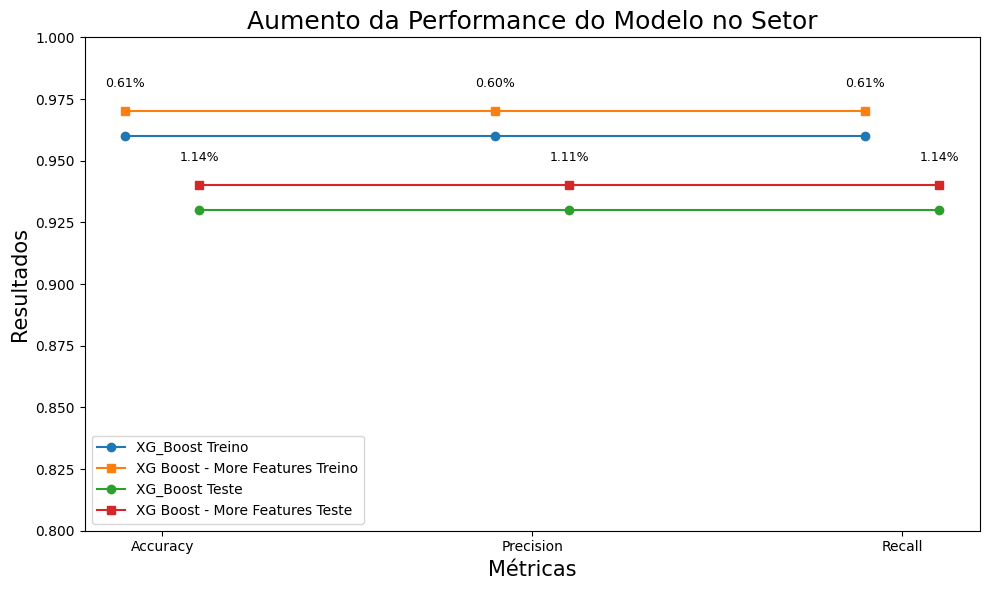

In [256]:
# Preparing the data
metrics = ['Accuracy', 'Precision', 'Recall']
types = ['Treino', 'Teste']
x = np.arange(len(metrics))  # the label locations

fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the data for both models
for i, type in enumerate(types):
    xg_boost_scores = data_performance.loc[[f'{metric} {type}' for metric in metrics], 'XG_Boost']
    xg_boost_more_features_scores = data_performance.loc[[f'{metric} {type}' for metric in metrics], 'XG Boost - More Features']
    
    # Line plots for each model
    line1, = ax.plot(x + i*0.2, xg_boost_scores, marker='o', linestyle='-', label=f'XG_Boost {type}')
    line2, = ax.plot(x + i*0.2, xg_boost_more_features_scores, marker='s', linestyle='-', label=f'XG Boost - More Features {type}')
    
    # Annotating the uplift for each metric
    for j, metric in enumerate(metrics):
        uplift = data_performance.loc[f'{metric} {type}', 'uplift']
        higher_score = max(xg_boost_scores.iloc[j], xg_boost_more_features_scores.iloc[j])
        ax.text(x[j] + i*0.2, higher_score + 0.01, f'{uplift}', ha='center', fontsize=9, bbox=dict(facecolor='white', edgecolor='none', pad=2))

# Adding some text for labels, title, and custom x-axis tick labels, etc.
ax.set_ylabel('Resultados', size=15)
ax.set_xlabel('Métricas', size=15)
ax.set_title('Aumento da Performance do Modelo no Setor', size=18)
ax.set_xticks(x + 0.1)  # Adjusting x-ticks to be in the middle of the groups
ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylim(0.8, 1)

fig.tight_layout()
plt.show()

In [175]:
print("Classification Report:")
print(classification_report(y_test_2.to_list(), y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1248
           1       0.89      0.72      0.80       133
           2       0.94      0.98      0.96      1522
           3       0.82      0.72      0.77       298
           4       0.97      0.99      0.98       332
           5       0.83      0.75      0.79       138
           6       1.00      1.00      1.00         2
           7       0.79      0.75      0.77        20
           8       1.00      0.99      1.00       533
           9       1.00      1.00      1.00         5
          10       1.00      1.00      1.00         4
          11       0.00      0.00      0.00         1
          13       1.00      0.80      0.89         5

    accuracy                           0.94      4241
   macro avg       0.86      0.82      0.84      4241
weighted avg       0.94      0.94      0.94      4241



/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/enderson.santos/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

# Analysing results that failed

- HRV
- 'IRN'
- '5D'
- 

In [131]:
df_clean[df_clean.TerritorioCon == 'GBR']

,CodEntidadeRef,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,CodEntidadeCon,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor,tokenized_Descricao_text,avg_embedding
35,0011,A,F3_P,NWG Float 13/01/26,07,2138005O9XJIJN4JPN90,S122,GBR,6,0,"[nwg, float]","[0.106123015, 0.049006544, 0.039887793, -0.105..."
40,0011,A,F3_P,IMBLN 1.125 14/8/23,07,2138008L3B3MCG1DFS50,S125,GBR,6,5,[imbln],"[0.0007223332, 0.004438957, 0.007668053, 0.007..."
76,0011,A,F3_P,HSBC Float 24/09/26,08,F0HUI1NY1AZMJMD8LP67,S127,GBR,6,3,"[hsbc, float]","[0.18909998, 0.07456243, 0.009489806, -0.13687..."
81,0011,A,F3_P,"BATSL 2,375 19/01/23",08,21380041YBGOQDFAC823,S125,GBR,6,5,[batsl],"[0.006692107, 0.0085775135, -0.008735614, -0.0..."
82,0011,A,F3_P,BATSLN .875 13/10/23,08,21380041YBGOQDFAC823,S127,GBR,6,3,[batsln],"[0.0070364177, 0.004681741, 0.004979764, -0.00..."
...,...,...,...,...,...,...,...,...,...,...,...,...
41378,1503,P,F4,GBR11200007-22 Catherine 2% 20201215 20,07,_X,S122,GBR,6,0,"[gbr, catherine]","[0.018044705, 0.04555394, -0.014981359, -0.014..."
41379,1503,P,F4,GBR11200007-13 Catherine 2% 20190701 20,07,_X,S122,GBR,6,0,"[gbr, catherine]","[0.018044705, 0.04555394, -0.014981359, -0.014..."
41394,1503,P,F4,GBR11200005-30 Patrick 2% 20211224 2022,10,_X,S122,GBR,6,0,"[gbr, patrick]","[0.023524022, 0.050343737, -0.016882353, -0.01..."
41395,1503,P,F4,GBR11200006-30 Patrick 2% 20211224 2022,06,_X,S122,GBR,6,0,"[gbr, patrick]","[0.023524022, 0.050343737, -0.016882353, -0.01..."


In [130]:
#return_embeedings('AFDB 5.75 Perp')
return_embeedings('Carlyle Europ PatIII', word2vec_model, simple_preprocess, clf_ter, clf_sec, inverted_mapping_ter, inverted_mapping_sec)

(['USA'], ['S124'])

# Training with the whole data

Vamos treinar agora o modelo com os dados todos. São exatamente os mesmos passos aplicados aos dados todos

In [19]:
df = pd.read_excel('../../data/01.Dataset FI_06032024.xlsx', sheet_name=2)

In [20]:
df_clean = df.copy("../data_missing/sampled_indices.csv")

In [21]:
data_eval = df_clean.sample(1000, random_state=42)
not_sampled_mask = ~df_clean.index.isin(data_eval)  # Create a boolean mask for non-sampled rows
df_clean = df_clean[not_sampled_mask]


data_pred = df_clean.sample(1000, random_state=42)
not_sampled_mask = ~df_clean.index.isin(data_pred)
df_clean = df_clean[not_sampled_mask]

In [22]:
df_clean.to_csv("../data_train/data_train.csv")
data_eval.to_csv("../data_train/data_eval.csv")
data_pred.to_csv("../data_missing/data_pred.csv")

In [23]:
# Get unique categories from 'TerritorioCon' column
unique_categories_ter = df_clean['TerritorioCon'].unique()
category_mapping_ter = dict(zip(unique_categories_ter, range(len(unique_categories_ter))))
inverted_mapping_ter = {value: key for key, value in category_mapping_ter.items()}

unique_categories_sec = df_clean["SetorInstitucionalCon"].unique()
category_mapping_sec = dict(zip(unique_categories_sec, range(len(unique_categories_sec))))
inverted_mapping_sec = {value: key for key, value in category_mapping_sec.items()}

df_clean["encoded_label_territorio"] = df_clean["TerritorioCon"].apply(encode_target, args=[category_mapping_ter])
df_clean["encoded_label_setor"] = df_clean['SetorInstitucionalCon'].apply(encode_target, args=[category_mapping_sec])

In [24]:
df_clean['tokenized_Descricao_text'] = df_clean['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
word2vec_model = Word2Vec(sentences=df_clean['tokenized_Descricao_text'], vector_size=100, window=5, min_count=1, workers=4)

In [25]:
df_clean['tokenized_Descricao_text'] = df_clean['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
word2vec_model = Word2Vec(sentences=df_clean['tokenized_Descricao_text'], vector_size=100, window=5, min_count=1, workers=4)

df_clean['avg_embedding'] = df_clean['tokenized_Descricao_text'].apply(compute_avg_embedding)
X = df_clean['avg_embedding'].apply(pd.Series).to_numpy()
y1 = df_clean['encoded_label_territorio']
y2 = df_clean['encoded_label_setor']
embed_data = pd.DataFrame(X)

In [43]:
df_clean.head()

,CodEntidadeRef,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,CodEntidadeCon,SetorInstitucionalCon,TerritorioCon,encoded_label_territorio,encoded_label_setor,tokenized_Descricao_text,avg_embedding
0,0011,A,F22,BST Futuros 2.90%,01,549300URJH9VSI58CS32,S122,PRT,0,0,"[bst, futuros]","[0.16896594, 0.21082236, 0.2087562, 0.1661322,..."
1,0011,A,F22,BPI EUR 0.00%,01,3DM5DPGI3W6OU6GJ4N92,S122,PRT,0,0,"[bpi, eur]","[-0.36473963, 0.572219, 0.08754694, 0.00742135..."
2,0011,A,F22,BST Futuros 2.65%,01,549300URJH9VSI58CS32,S122,PRT,0,0,"[bst, futuros]","[0.16896594, 0.21082236, 0.2087562, 0.1661322,..."
3,0011,A,F22,BST EUR 3.15%,01,549300URJH9VSI58CS32,S122,PRT,0,0,"[bst, eur]","[-0.054259613, 0.39159432, 0.23001918, 0.19084..."
4,0011,A,F22,BST EUR 2.65%,01,549300URJH9VSI58CS32,S122,PRT,0,0,"[bst, eur]","[-0.054259613, 0.39159432, 0.23001918, 0.19084..."
...,...,...,...,...,...,...,...,...,...,...,...,...
42402,2039,P,F4,"Empréstimo Vic Management 0,01%",_Z,514925507,S11,PRT,0,2,"[empréstimo, vic, management]","[0.00058524497, 0.177311, -0.040029775, -0.009..."
42403,2040,P,F3_P,Outros Passivos,07,549300OZ46BRLZ8Y6F65,S122,BEL,10,0,"[outros, passivos]","[0.0058196564, 0.025449172, -0.01679747, -0.00..."
42404,2040,P,F4,"Empréstimo Vic One Pest Sup 0,01%",_Z,514925507,S11,PRT,0,2,"[empréstimo, vic, one, pest, sup]","[0.010988126, 0.13505054, -0.03513687, -0.0063..."
42405,2040,P,F4,"Empréstimo Vic Management 0,01%",_Z,514925507,S11,PRT,0,2,"[empréstimo, vic, management]","[0.00058524497, 0.177311, -0.040029775, -0.009..."


In [26]:
new_features = ["TipoInformacao", "TipoInstrumento", "MaturidadeOriginal"]
df_to_get_dummies = df_clean[new_features]
dummies = pd.get_dummies(df_to_get_dummies)

new_df_to_train = pd.concat([embed_data, dummies], axis=1)

In [27]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y2, test_size=0.2, random_state=42)

In [28]:
clf_ter = XGBClassifier(random_state=42, max_depth=5)
clf_ter.fit(X, y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [29]:
clf_sec = XGBClassifier(random_state=42, max_depth=5)
clf_sec.fit(X, y2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [30]:
y_pred_test = clf_ter.predict(X)
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_ter)

# Evaluate accuracy
accuracy_test = accuracy_score(y1.to_list(), y_pred_test)
print("Accuracy Ter:", accuracy_test)

Accuracy Ter: 0.96856651024595


In [31]:
print("Classification Report:")
print(classification_report(y1.to_list(), y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13009
           1       0.96      0.97      0.96      5416
           2       0.95      0.91      0.93      2275
           3       0.98      0.92      0.95      2870
           4       0.95      0.95      0.95      2521
           5       0.98      0.96      0.97      3344
           6       0.95      0.93      0.94      1671
           7       1.00      0.96      0.98       263
           8       1.00      0.98      0.99       217
           9       0.93      1.00      0.96       551
          10       1.00      1.00      1.00       333
          11       0.98      0.98      0.98      3195
          12       0.99      0.97      0.98      2044
          13       0.99      0.99      0.99      1730
          14       0.98      0.99      0.99       359
          15       0.99      0.99      0.99       400
          16       1.00      0.92      0.96       136
    

/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/enderson.santos/anaconda3/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [32]:
y_pred_test = clf_sec.predict(X)
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_sec)

# Evaluate accuracy
accuracy_test = accuracy_score(y2.to_list(), y_pred_test)
print("Accuracy Sec:", accuracy_test)

Accuracy Sec: 0.9508335887943028


In [33]:
print("Classification Report:")
print(classification_report(y2.to_list(), y_pred_test))

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97     12695
           1       0.88      0.76      0.81      1337
           2       0.95      0.98      0.97     15151
           3       0.86      0.75      0.80      2857
           4       0.95      1.00      0.98      3303
           5       0.85      0.79      0.82      1400
           6       1.00      1.00      1.00        60
           7       0.86      0.94      0.89       264
           8       0.99      0.99      0.99      5171
           9       0.91      1.00      0.95        63
          10       0.89      0.91      0.90        45
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00         2
          13       0.88      0.96      0.92        52

    accuracy                           0.95     42407
   macro avg       0.93      0.93      0.93     42407
weighted avg       0.95      0.95      0.95     42407



In [34]:
y_pred_test = clf_ter.predict_proba(X)

In [35]:
y_pred_test = clf_sec.predict_proba(X)

In [36]:
y_pred_test.max(axis=1).min()

0.25756827

In [37]:
clf_ter.predict_proba(X[:1]).max()

0.9999988

In [38]:
!ls ../final_data

df_final.csv


In [95]:
pred_with_prob = pd.read_csv("../final_data/df_final.csv")

pred_with_prob[pred_with_prob["ter_probabilidade"] < 0.5]

,Unnamed: 0.1,Unnamed: 0,CodEntidadeRef,TipoInformacao,TipoInstrumento,DescricaoInstrumento,MaturidadeOriginal,CodEntidadeCon,SetorInstitucionalCon,TerritorioCon,sec_pred,ter_pred,sec_probabilidade,ter_probabilidade
18,18,12378,0605,A,F3_P,"CS 2,125% 13/10/26",07,ANGGYXNX0JLX3X63JN86,S126,CHE,S122,CHE,0.671,0.439
22,22,17713,1021,A,F3_P,CS 1% 06/2027,08,549300506SI9CRFV9Z86,S122,CHE,S122,CHE,0.671,0.439
42,42,4506,0153,A,F3_P,DTRGR Float 06/2023,06,724500G15MVL6UCWXF95,S125,NLD,S127,NLD,0.868,0.287
55,55,9273,0440,A,F511,LA FRANCAISE DJXSAEM,_Z,969500R4CLSQFTYYI535,S11,FRA,S124,FRA,0.315,0.472
65,65,7475,0276,A,F3_P,BUNDESSCHATZANWEIS 2.2% 12/12/2024,07,529900AQBND3S6YJLY83,S1311,DEU,S1311,USA,0.495,0.434
83,83,27792,1460,A,F511,AXA-UAP,_Z,F5WCUMTUM4RKZ1MAIE39,S126,FRA,S128,FRA,0.868,0.435
104,104,13415,0647,A,F3_P,HEIBOS 3.248 PERP,08,549300TJR3PR8EXILG79,S11,SWE,S11,SWE,0.861,0.467
137,137,42325,1994,P,F4,Empréstimo - PNI PORTUGAL,07,980662796,S127,LUX,S122,LUX,0.949,0.454
161,161,41628,1620,P,F4,"Emprestimo Joao F Marques, S.A. N/Remun.",07,_X,S122,PRT,S11,PRT,0.789,0.478
190,190,37478,1775,A,F22,Fornecedores,01,_X,S122,PRT,S122,PRT,0.978,0.483


## Mais Features no dataset final e avaliar performance

In [41]:
df_clean = df.copy("../data_missing/sampled_indices.csv")

In [42]:
# Get unique categories from 'TerritorioCon' column
unique_categories_ter = df_clean['TerritorioCon'].unique()
category_mapping_ter = dict(zip(unique_categories_ter, range(len(unique_categories_ter))))
inverted_mapping_ter = {value: key for key, value in category_mapping_ter.items()}

unique_categories_sec = df_clean["SetorInstitucionalCon"].unique()
category_mapping_sec = dict(zip(unique_categories_sec, range(len(unique_categories_sec))))
inverted_mapping_sec = {value: key for key, value in category_mapping_sec.items()}

df_clean["encoded_label_territorio"] = df_clean["TerritorioCon"].apply(encode_target, args=[category_mapping_ter])
df_clean["encoded_label_setor"] = df_clean['SetorInstitucionalCon'].apply(encode_target, args=[category_mapping_sec])

In [43]:
df_clean['tokenized_Descricao_text'] = df_clean['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
word2vec_model = Word2Vec(sentences=df_clean['tokenized_Descricao_text'], vector_size=100, window=5, min_count=1, workers=4)

In [48]:
df_clean['avg_embedding'] = df_clean['tokenized_Descricao_text'].apply(compute_avg_embedding)
X = df_clean['avg_embedding'].apply(pd.Series).to_numpy()
y1 = df_clean['encoded_label_territorio']
y2 = df_clean['encoded_label_setor']
embed_data = pd.DataFrame(X)

new_features = ["TipoInformacao", "TipoInstrumento", "MaturidadeOriginal"]
df_to_get_dummies = df_clean[new_features]
dummies = pd.get_dummies(df_to_get_dummies)

new_df_to_train = pd.concat([embed_data, dummies], axis=1)

In [46]:
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(new_df_to_train, y1, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(new_df_to_train, y2, test_size=0.2, random_state=42)

In [50]:
clf_ter = XGBClassifier(random_state=42, max_depth=5)
clf_ter.fit(new_df_to_train, y1)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [51]:
clf_sec = XGBClassifier(random_state=42, max_depth=5)
clf_sec.fit(new_df_to_train, y2)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [52]:
y_pred_test = clf_ter.predict(new_df_to_train)
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_ter)

# Evaluate accuracy
accuracy_test = accuracy_score(y1.to_list(), y_pred_test)
print("Accuracy Ter:", accuracy_test)

Accuracy Ter: 0.9794845190652487


In [53]:
y_pred_test = clf_sec.predict(new_df_to_train)
pred_test_str = map_numbers_to_categories(y_pred_test, inverted_mapping_sec)

# Evaluate accuracy
accuracy_test = accuracy_score(y2.to_list(), y_pred_test)
print("Accuracy Sec:", accuracy_test)

Accuracy Sec: 0.9589454571179287


Função que permite usar o modelo e retornar as previsões para novas entradas

In [39]:
def return_embeedings(string, word2vec_model, simple_preprocess, clf_t, clf_s, inverted_mapping_t, inverted_mapping_s):
    case = pd.DataFrame({'DescricaoInstrumento': [string]})
    case['tokenized_Descricao_text'] = case['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
    case['avg_embedding'] = case['tokenized_Descricao_text'].apply(compute_avg_embedding)
    
    X = case['avg_embedding'].apply(pd.Series).to_numpy()
    
    prediction_t = clf_t.predict(X)
    str_pred_t = map_numbers_to_categories(prediction_t, inverted_mapping_t)
    
    prediction_s = clf_s.predict(X)
    str_pred_s = map_numbers_to_categories(prediction_s, inverted_mapping_s)
    
    prediction_s_prob = clf_sec.predict_proba(X).max()
    prediction_t_prob = clf_ter.predict_proba(X).max()
    
    return str_pred_t, str_pred_s #, prediction_t_prob, prediction_s_prob

In [100]:
str_to_try = 'HEATHROW FUNDING LTD 1.50% 12/10/2027'
str_pred_t, str_pred_s, prediction_s_prob, prediction_t_prob = return_embeedings(str_to_try, word2vec_model, simple_preprocess, clf_ter, clf_sec, inverted_mapping_ter, inverted_mapping_sec)

In [101]:
return_embeedings(str_to_try, word2vec_model, simple_preprocess, clf_ter, clf_sec, inverted_mapping_ter, inverted_mapping_sec)

(['JEY'], ['S125'], 0.98384386, 0.8323205)

In [ ]:
all_str_ter = []
all_str_sec = []

for i in range(len(sampled_indices)):

    string = sampled_indices.DescricaoInstrumento.iloc[i]
    str_pred_t, str_pred_s = return_embeedings(string, word2vec_model, simple_preprocess, clf_ter, clf_sec, inverted_mapping_ter, inverted_mapping_sec)
    
    all_str_ter.append(str_pred_t[0])
    all_str_sec.append(str_pred_s[0])
    
sampled_indices["sec_pred"] = all_str_sec  
sampled_indices["ter_pred"] = all_str_ter

## Gradio App

Criando um aplicativo gradio para demostrar o trabalho

In [41]:
def return_embeedings_(string):
    case = pd.DataFrame({'DescricaoInstrumento': [string]})
    case['tokenized_Descricao_text'] = case['DescricaoInstrumento'].apply(lambda x: simple_preprocess(x))
    case['avg_embedding'] = case['tokenized_Descricao_text'].apply(compute_avg_embedding)

    X = case['avg_embedding'].apply(pd.Series).to_numpy()

    try:
        prediction_t = clf_ter.predict(X)
        str_pred_t = map_numbers_to_categories(prediction_t, inverted_mapping_ter)

        prediction_s = clf_sec.predict(X)
        str_pred_s = map_numbers_to_categories(prediction_s, inverted_mapping_sec)
        prediction_s_prob = clf_sec.predict_proba(X).max()
        prediction_t_prob = clf_ter.predict_proba(X).max()

        return str(str_pred_t[0]), str(str_pred_s[0]) #, prediction_t_prob, prediction_s_prob
           
    except Exception as e:
        return "An error occurred: " + str(e)

In [42]:
examples = [
    ["HEATHROW FUNDING LTD 1.50% 12/10/2027"],
    ["FORTUM 1.625% A:27/02/2026"],
    ["BAC FLOAT 25/4/24"],
    ["DP DP 4M 0% 16/12/21CGD 0.00% 2020-12-16"],
]

# Create the Gradio app
iface = gr.Interface(
    # Argument 1: function (Required)
    fn=return_embeedings_,  # The function you want to expose as an interface

    # Argument 2: input components (Required)
    inputs=[gr.Textbox(lines=5, placeholder="Enter a text description")],  # Defines user input

    # Argument 3: examples (Optional)
    examples=examples,  # List of example text descriptions (or tuples with predictions)

    # Argument 4: output components (Required)
    outputs=[
        gr.Textbox(label="Prediction Territory"),
        gr.Textbox(label="Prediction Sector"),
        #gr.Textbox(label="Prediction Probability Territory"),
        #gr.Textbox(label="Prediction Probability Sector"),
    ],  # Defines how to display the output
)

# Launch the app
iface.launch()

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


## Saving and reading models

In [236]:
with open('model_data.pkl', 'wb') as f:
    pickle.dump(inverted_mapping_ter, f)
    pickle.dump(inverted_mapping_sec, f)
    pickle.dump(word2vec_model, f)
    pickle.dump(clf_sec, f)
    pickle.dump(clf_ter, f)

In [238]:
with open('model_data.pkl', 'rb') as f:
    # Load the data objects in the same order they were saved
    inverted_mapping_ter = pickle.load(f)
    inverted_mapping_sec = pickle.load(f)
    word2vec_model = pickle.load(f)
    clf_sec = pickle.load(f)
    clf_ter = pickle.load(f)